In [3]:
# !pip install bert-serving-client
# !pip install -U bert-serving-server[http]
# !wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
# !unzip uncased_L-12_H-768_A-12.zip
# %tensorflow_version 1.x
# !nohup bert-serving-start -max_seq_len=150 -model_dir=./uncased_L-12_H-768_A-12 > out.file 2>&1 &
# !pip install --upgrade gspread
# !pip install --upgrade googletrans
# !pip install translate
# !pip install spacy==2.3.4
# !python -m spacy download en_core_web_md

     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 358kB 14.9MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=7880c183e02a431d67327d995fe5a85901bda504eaddb5f8752e814eb375f0a2
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
--2020-12-07 01:17:02--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   120MB/s    in 3.2s    

2020-12-07 01:17:06 (120 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028

In [78]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from bert_serving.client import BertClient
import tensorflow as tf
from sklearn.metrics import recall_score, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering
from math import trunc
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
import pickle
import re
import spacy
from google.colab import drive
drive.mount('/content/drive')
import os
import nltk
bc = BertClient()

nltk.download('stopwords')
# os.environ["CUDA_VISIBLE_DEVICES"]= ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Carregando Datasets

In [5]:
local_folder = '/content/drive/Shareddrives/Hackathon Visagio'


In [70]:
df_aosfatos = pd.read_excel(local_folder + '/Bases_VisagioHackathon/Base_tweets_saúde_Aos_Fatos.xlsx', sheet_name=None)

df_Base_News_Releases = pd.read_csv(local_folder + '/Bases_VisagioHackathon/FakeHealthData/Base News Releases.csv', sep=';', index_col=0)
df_Base_Story = pd.read_csv(local_folder + '/Bases_VisagioHackathon/FakeHealthData/Base Story.csv', sep=';', index_col=0)
df_news_tweets = pd.read_csv(local_folder + '/Bases_VisagioHackathon/FakeHealthData/news_tweets.csv', sep=';',)# index_col=0)
df_story_tweets = pd.read_csv(local_folder + '/Bases_VisagioHackathon/FakeHealthData/story_tweets.csv', sep=';', header=None)#, index_col=0)
df_story_tweets.columns = ['key', 'id', 'tweets']
df_news_tweets['id'] = (df_news_tweets.key.str.split('_', expand=True)[2]).astype(int)
df_story_tweets['id'] = (df_news_tweets.key.str.split('_', expand=True)[2]).astype(int) + 299
df_tweets = pd.concat([df_news_tweets, df_story_tweets], ignore_index=True)

df_kaggle_visagio_true = pd.read_csv(local_folder + '/kaggle_visagio/True.csv', sep=',')
df_kaggle_visagio_fake = pd.read_csv(local_folder + '/kaggle_visagio/Fake.csv', sep=',')


dict_keys(['mar-abr', 'abr-mai', 'mai-jun', 'jun-jul', 'jul-ago', 'ago-set'])
(300, 48)
(300, 48)
(925, 3)
(5287, 3)
(23481, 4)
(21417, 4)


# Dataset Kaggle True/Fake - Referência Externa


Label para Fake News: 0 // Label para True: 1

In [9]:
df_kaggle_visagio_fake['label'] = [0]*df_kaggle_visagio_fake.shape[0]
df_kaggle_visagio_true['label'] = [1]*df_kaggle_visagio_true.shape[0]
df_kaggle_visagio = pd.concat([df_kaggle_visagio_fake, df_kaggle_visagio_true])
df_kaggle_visagio['title'] = df_kaggle_visagio['title'].str.strip()
idx = ['id_'+str(i) for i in range(df_kaggle_visagio.shape[0])]
df_kaggle_visagio.index = idx
df_kaggle_visagio = df_kaggle_visagio[df_kaggle_visagio['title'].str.len() > 10]
df_kaggle_visagio = df_kaggle_visagio[df_kaggle_visagio['title'].str.count(' ') > 2]
df_kaggle_visagio.dropna(subset=['title'], inplace=True)

(44898, 5)
(44887, 5)


In [10]:
df_kaggle_visagio.head()

,title,text,subject,date,label
id_0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
id_1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
id_2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
id_3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
id_4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [11]:
stopwords_en = stopwords.words('english')

fake_titles = " ".join([t for t in df_kaggle_visagio_fake['title']])
true_titles = " ".join([t for t in df_kaggle_visagio_true['title']])

fake_wordcloud = WordCloud(stopwords=stopwords_en,
                      background_color='white', width=800,                            
                      height=800).generate(fake_titles)

true_wordcloud = WordCloud(stopwords=stopwords_en,
                      background_color='white', width=800,                            
                      height=800).generate(true_titles)

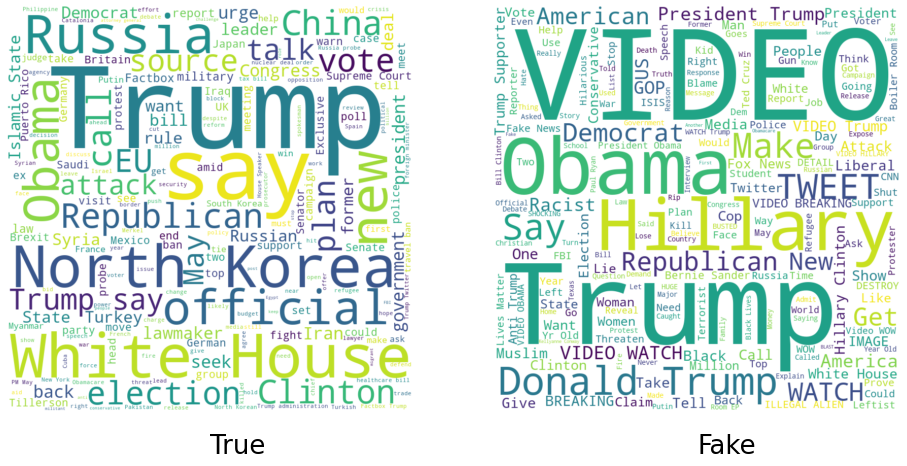

In [12]:
## Palavras Relevantes em cada classificação:
fig, ax = plt.subplots(1,2, figsize=(16,8))            
ax[0].imshow(true_wordcloud, interpolation='bilinear')
ax[0].set_axis_off()
ax[0].text(0.5, -0.1, 'True', transform=ax[0].transAxes, fontsize=26)

ax[1].imshow(fake_wordcloud, interpolation='bilinear')
ax[1].set_axis_off()
ax[1].text(0.5, -0.1, 'Fake', transform=ax[1].transAxes, fontsize=26)
plt.show()

### Limpeza do Dataset:
Removendo palavras em letras maiúsculas dentro de parênteses no final dos títulos - ex: (VIDEO), (TWEET)

In [13]:
new_titles = []


for t1 in df_kaggle_visagio['title'].str.split(' ', n=2):
#     print(t1)
    if len(t1) < 2: new_titles.append('')

    elif ( t1[0][0] in ['(', '['] ) and ( t1[0][-1] in [')', ']'] ):
        new_titles.append(' '.join(t1[1:]))

    elif ( t1[0][0] in ['(', '['] ) and ( t1[1][-1] in [')', ']'] ):
        new_titles.append(' '.join(t1[-1]))

    else: 
        new_titles.append(' '.join(t1))
df_kaggle_visagio['title'] = new_titles

df_kaggle_visagio.dropna(subset=['title'], inplace=True)

new_titles = []


for t2 in df_kaggle_visagio['title'].str.rsplit(' ', n=2):
   

    if len(t2) < 2: new_titles.append('')

    elif ( len(t2[-1])==0 or t2[-1] in ['(', '[']) and (len(t2[-1])==0 or t2[-1][-1] in [')', ']']):
        new_titles.append(' '.join(t2[:-1]))

    elif (len(t2[-2]) == 0 or t2[-2][0] in ['(', '[']) and (len(t2[-1])==0 or t2[-1][-1] in [')', ']']):
        new_titles.append(t2[0])

    else: 
        new_titles.append(' '.join(t2))
    
df_kaggle_visagio['title'] = new_titles

df_kaggle_visagio.dropna(subset=['title'], inplace=True)

### Criando Parâmetros para modelo de AI

In [14]:
total_upper_rate = []
first_1_upper = []
first_3_upper_count = []

for i in range(df_kaggle_visagio.shape[0]):
    upper_count = 0
    first_3 = 0
    
    words = df_kaggle_visagio['title'].iloc[i]
    words = words.split(' ')
    
    for w in words:
        if w.isupper(): upper_count += 1
            
    total_upper_rate.append(upper_count/len(words))
            
    
    first_1_upper.append(words[0].isupper())
    
    
    for w in words[:3]:
        if w.isupper(): first_3 += 1
            
    first_3_upper_count.append(first_3)
    

df_kaggle_visagio['total_upper_rate'] = total_upper_rate
df_kaggle_visagio['first_1_upper'] = first_1_upper
df_kaggle_visagio['first_3_upper_count'] = first_3_upper_count
df_kaggle_visagio['exclamation_count'] = df_kaggle_visagio['title'].str.count('!')
df_kaggle_visagio['title_len'] = df_kaggle_visagio['title'].str.len()

### Tratamento de Dados + criação de representação vetorial das manchetes (BERT)

In [21]:
numerical_parameters = np.array(df_kaggle_visagio[['total_upper_rate', 'first_3_upper_count', 'exclamation_count']])

normalizer = Normalizer() 
normalizer.fit(numerical_parameters.T)

X = normalizer.transform(numerical_parameters.T)

X = X.T 

X = np.append(X, (np.array(df_kaggle_visagio['first_1_upper'])*1.0).reshape(-1, 1), axis=1)

In [22]:
Y = np.array(df_kaggle_visagio['label']).reshape(-1, 1)

Y = to_categorical(Y)

In [23]:
data_path = local_folder + '/Models/df_kaggle_visagio/data/'

In [24]:
df_kaggle_visagio.to_csv(data_path + 'df.csv')

np.save(data_path + 'titles.npy', np.array(df_kaggle_visagio['title']))
np.save(data_path + 'total_upper_rate.npy', np.array(df_kaggle_visagio['total_upper_rate']))
np.save(data_path + 'first_1_upper.npy', np.array(df_kaggle_visagio['first_1_upper']))
np.save(data_path + 'first_3_upper_count.npy', np.array(df_kaggle_visagio['first_3_upper_count']))
np.save(data_path + 'label.npy', np.array(df_kaggle_visagio['label']))

np.save(data_path + 'X.npy', X)
np.save(data_path + 'Y.npy', Y)

In [25]:
embeddings_titles_kaggle_visagio = np.load(data_path+ 'EMB.npy')

### Análise de clusterização (KMeans)

In [26]:
bert_pca = PCA(n_components=2, random_state=10)
bert_arr_pca = bert_pca.fit_transform(embeddings_titles_kaggle_visagio)

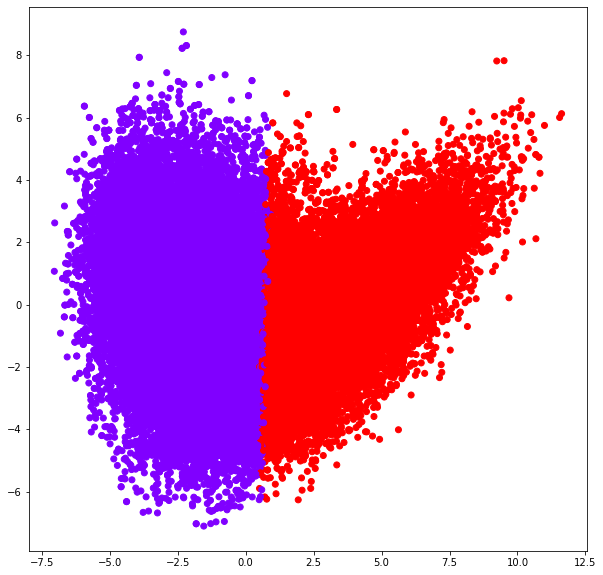

CPU times: user 16.4 s, sys: 3.22 s, total: 19.6 s
Wall time: 15.6 s


In [27]:
%%time

bert_kmeans = KMeans(n_clusters=2, random_state=2)

bert_kmeans.fit(embeddings_titles_kaggle_visagio)

plt.figure(figsize=(10,10))
plt.scatter(bert_arr_pca[:,0], bert_arr_pca[:,1], c=bert_kmeans.labels_, cmap='rainbow')
# plt.scatter(bert_kmeans.cluster_centers_[:,0], bert_kmeans.cluster_centers_[:,1], color='black', marker = 'x')
plt.show()

# Criação e Treinamento de modelos de Detecção de Fake News (TensorFlow)

In [ ]:
# data_path = './Models/df_kaggle_visagio/data/'

X = np.load(data_path + 'X.npy')
EMB = np.load(data_path + 'EMB.npy')
Y = np.load(data_path + 'Y.npy')

In [ ]:
def generate_model_0(X, EMB, Y):
    
    x_layer = tf.keras.layers.Input(shape= (X.shape[1]), name = 'X')
    embeddings = tf.keras.layers.Input(shape= (EMB.shape[1], 1), name = 'Embeddings')
    
    conv1 = tf.keras.layers.Conv1D(3, 128, activation='relu', name = 'conv1')(embeddings)
    
    maxpool1 = tf.keras.layers.MaxPool1D(3, name = 'MaxPool1')(conv1)
    
    conv2 = tf.keras.layers.Conv1D(3, 64, activation='relu', name = 'conv2')(maxpool1)
    
    maxpool2 = tf.keras.layers.MaxPool1D(4, name = 'MaxPool2')(conv2)
    
    flatten = tf.keras.layers.Flatten()(maxpool2)
    
    dense1 = tf.keras.layers.Dense(64, activation='relu', name = 'dense1')(flatten)
    
    
    
    dense2 = tf.keras.layers.Dense(16, activation='relu', name = 'dense2')(x_layer)
    
    dense3 = tf.keras.layers.Dense(8, activation='relu', name = 'dense3')(dense2)
    
    
    
    
    
    merge = tf.keras.layers.concatenate([dense1, dense3], axis=1, name = 'merge')
    
    
    dense4 = tf.keras.layers.Dense(8, activation='relu', name = 'dense4')(merge)
    
    
    y_layer = tf.keras.layers.Dense(2, activation='softmax', name = 'output_layer')(dense4)
    
    model = tf.keras.models.Model(inputs=[x_layer, embeddings], outputs = [y_layer], name = 'model_0')
    
    return model

In [ ]:
def generate_model_1(X, EMB, Y):
    
    x_layer = tf.keras.layers.Input(shape= (X.shape[1]), name = 'X')
    embeddings = tf.keras.layers.Input(shape= (EMB.shape[1], 1), name = 'Embeddings')
    
    conv1 = tf.keras.layers.Conv1D(3, 128, activation='relu', name = 'conv1')(embeddings)
    
    maxpool1 = tf.keras.layers.MaxPool1D(3, name = 'MaxPool1')(conv1)
    
    conv2 = tf.keras.layers.Conv1D(3, 64, activation='relu', name = 'conv2')(maxpool1)
    
    maxpool2 = tf.keras.layers.MaxPool1D(4, name = 'MaxPool2')(conv2)
    
    flatten = tf.keras.layers.Flatten()(maxpool2)
    
    dense1 = tf.keras.layers.Dense(32, activation='relu', name = 'dense1')(flatten)
    
    dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
    
    dense2 = tf.keras.layers.Dense(16, activation='relu', name = 'dense2')(x_layer)
    
    dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
    
    dense3 = tf.keras.layers.Dense(8, activation='relu', name = 'dense3')(dropout2)
    
    
    
    
    
    merge = tf.keras.layers.concatenate([dropout1, dense3], axis=1, name = 'merge')
    
    
    dense4 = tf.keras.layers.Dense(8, activation='relu', name = 'dense4')(merge)
    
    
    y_layer = tf.keras.layers.Dense(2, activation='softmax', name = 'output_layer')(dense4)
    
    model = tf.keras.models.Model(inputs=[x_layer, embeddings], outputs = [y_layer], name = 'model_1')
    
    return model

In [ ]:
def generate_model_2(X, EMB, Y):
    
    x_layer = tf.keras.layers.Input(shape= (X.shape[1]), name = 'X')
    embeddings = tf.keras.layers.Input(shape= (EMB.shape[1], 1), name = 'Embeddings')
    
    conv1 = tf.keras.layers.Conv1D(3, 64, activation='relu', name = 'conv1')(embeddings)
    
    maxpool1 = tf.keras.layers.MaxPool1D(5, name = 'MaxPool1')(conv1)
    
    conv2 = tf.keras.layers.Conv1D(3, 32, activation='relu', name = 'conv2')(maxpool1)
    
    maxpool2 = tf.keras.layers.MaxPool1D(5, name = 'MaxPool2')(conv2)
    
    flatten = tf.keras.layers.Flatten()(maxpool2)
    
    dense1 = tf.keras.layers.Dense(16, activation='relu', name = 'dense1')(flatten)
    
    dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
    
    dense2 = tf.keras.layers.Dense(16, activation='relu', name = 'dense2')(x_layer)
    
    dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
    
    dense3 = tf.keras.layers.Dense(8, activation='relu', name = 'dense3')(dropout2)
    
    
    
    
    
    merge = tf.keras.layers.concatenate([dropout1, dense3], axis=1, name = 'merge')
    
    
    dense4 = tf.keras.layers.Dense(8, activation='relu', name = 'dense4')(merge)
    
    
    y_layer = tf.keras.layers.Dense(2, activation='softmax', name = 'output_layer')(dense4)
    
    model = tf.keras.models.Model(inputs=[x_layer, embeddings], outputs = [y_layer], name = 'model_2')
    
    return model

In [ ]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, custom_save_model, custom_save_model_filename, monitor):
        self.save_model = custom_save_model
        self.save_model_filename = custom_save_model_filename
        self.monitor = monitor
        # Initializing accuracies
        self.best_val_acc = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_val = logs.get(self.monitor)
        if current_val > self.best_val_acc:
            self.best_val_acc = current_val
            # self.save_model.save(self.save_model_filename, overwrite=True)

In [ ]:
def separate_data(X_array, E_array, Y_array, train_slice= 0.8, validation_slice= 0.1, random_state = 1):
    
    X_array, E_array, Y_array = shuffle(X_array, E_array, Y_array, random_state = random_state)
    
    
    end_train = trunc(X_array.shape[0]*train_slice)
    ini_test = end_train + trunc(X_array.shape[0]*validation_slice)
    
    # Titles indexes pointing to embeddings
    X_train = X_array[:end_train]
    X_val = X_array[end_train:ini_test]
    X_test = X_array[ini_test:]
    
    # Financial indexes
    E_train = E_array[:end_train]
    E_val = E_array[end_train:ini_test]
    E_test = E_array[ini_test:]
    
    # Predictions
    Y_train = Y_array[:end_train]
    Y_val = Y_array[end_train:ini_test]
    Y_test = Y_array[ini_test:]

    return X_train, X_val, X_test, E_train, E_val, E_test, Y_train, Y_val, Y_test


In [ ]:
X_train, X_val, X_test, E_train, E_val, E_test, Y_train, Y_val, Y_test = separate_data(X, EMB, Y)

In [ ]:
drive.mount("/content/drive", force_remount=True)
num_epochs = 300
verbose_mode = 1

for init in [7, 8, 10, 21, 101, 1000]:
    
    for batch in [50, 100, 200]:

        for model_number in [0, 1, 2]:
            
            print('\n'*3+'[TRAINING] Seed %i / Model %i / Batch %i' % (init, model_number, batch)+'\n'*3)
            
            model_filename = data_path + 'Models/df_kaggle_visagio/saved_models/' + 'model__init_%i__model_%i__batch_%i.hdf5' % (init, model_number, batch)
            history_filename = data_path + 'Models/df_kaggle_visagio/saved_models/' + 'history__init_%i__model_%i__batch_%i.p' % (init, model_number, batch)


            with tf.Graph().as_default():
                # Initializing seeds
                np.random.seed(init)
                tf.random.set_random_seed(init)

                model = eval('generate_model_'+str(model_number))(X, EMB, Y)

                model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['acc','mse'])

                history =  model.fit([X_train, E_train.reshape(-1, 768, 1)], Y_train,
                                        validation_data = [[X_val, E_val.reshape(-1, 768, 1)], Y_val],
                                        epochs = num_epochs,
                                        batch_size = batch,
                                        verbose = verbose_mode,
                                        shuffle = False,
                                        callbacks=[CustomModelCheckpoint(model, model_filename, monitor='val_acc')],
                                    )

            # pickle.dump(history.history, open(history_filename,'wb'))

Mounted at /content/drive



[TRAINING] Seed 7 / Model 0 / Batch 50



Train on 35216 samples, validate on 4402 samples
Epoch 1/300
35216/35216 [==============================] - 3s 91us/sample - loss: 0.2207 - acc: 0.9092 - mean_squared_error: 0.0662 - val_loss: 0.1286 - val_acc: 0.9552 - val_mean_squared_error: 0.0362
Epoch 2/300
35216/35216 [==============================] - 3s 87us/sample - loss: 0.1352 - acc: 0.9496 - mean_squared_error: 0.0382 - val_loss: 0.1100 - val_acc: 0.9609 - val_mean_squared_error: 0.0307
Epoch 3/300
35216/35216 [==============================] - 3s 89us/sample - loss: 0.1208 - acc: 0.9554 - mean_squared_error: 0.0340 - val_loss: 0.1041 - val_acc: 0.9634 - val_mean_squared_error: 0.0290
Epoch 4/300
35216/35216 [==============================] - 3s 92us/sample - loss: 0.1139 - acc: 0.9578 - mean_squared_error: 0.0321 - val_loss: 0.1020 - val_acc: 0.9627 - val_mean_squared_error: 0.0286
Epoch 5/300
35216/35216 [==============================] - 3s 85us/sampl

# Evaluation - Modelos de Detecção de Fake News (TensorFlow)

In [ ]:
results_path = data_path + 'Models/df_kaggle_visagio/results/'

results_dict = {}

for model_number in [0, 1, 2]:
    
    model_dict = {}
    
    for batch in [50, 100, 200]:
        model_dict[batch] = {}
        
        model_dict[batch]['train_acc'] = []
        model_dict[batch]['val_acc'] = []
        model_dict[batch]['test_acc'] = []

        model_dict[batch]['train_loss_hist'] = np.zeros((1, 300)) #Num Epochs 
        model_dict[batch]['val_loss_hist'] = np.zeros((1, 300)) #Num Epochs 
        model_dict[batch]['train_acc_hist'] = np.zeros((1, 300)) #Num Epochs 
        model_dict[batch]['val_acc_hist'] = np.zeros((1, 300)) #Num Epochs
        
        for init in [7, 8, 10, 21, 101, 1000]:
            
            print('[CALCULATING] Seed %i / Model %i / Batch %i' % (init, model_number, batch))
            
             
            
            model_filename = data_path + 'Models/df_kaggle_visagio/saved_models/' + 'model__init_%i__model_%i__batch_%i.hdf5' % (init, model_number, batch)
            history_filename = data_path + 'Models/df_kaggle_visagio/saved_models/' + 'history__init_%i__model_%i__batch_%i.p' % (init, model_number, batch)

            history = pickle.load(open(history_filename, 'rb'))
            model = tf.keras.models.load_model(model_filename, compile=False)
                        
            train_predictions = model.predict([X_train, E_train.reshape(-1, 768, 1)])
            val_predictions = model.predict([X_val, E_val.reshape(-1, 768, 1)])
            test_predictions = model.predict([X_test, E_test.reshape(-1, 768, 1)])
            
            train_acc = accuracy_score(Y_train.argmax(axis=1), train_predictions.argmax(axis=1))
            val_acc = accuracy_score(Y_val.argmax(axis=1), val_predictions.argmax(axis=1))
            test_acc = accuracy_score(Y_test.argmax(axis=1), test_predictions.argmax(axis=1))
            
            model_dict[batch]['train_acc'].append(train_acc)
            model_dict[batch]['val_acc'].append(val_acc)
            model_dict[batch]['test_acc'].append(test_acc)
            
            model_dict[batch]['train_loss_hist'] = np.append(model_dict[batch]['train_loss_hist'], np.array(history['loss']).reshape(1, -1), axis=0)
            model_dict[batch]['train_acc_hist'] = np.append(model_dict[batch]['train_acc_hist'], np.array(history['acc']).reshape(1, -1), axis=0)
            model_dict[batch]['val_loss_hist'] = np.append(model_dict[batch]['val_loss_hist'], np.array(history['val_loss']).reshape(1, -1), axis=0)
            model_dict[batch]['val_acc_hist'] = np.append(model_dict[batch]['val_acc_hist'], np.array(history['val_acc']).reshape(1, -1), axis=0)
            
        
#         print(model_dict[batch]['train_loss_hist'].shape)
        model_dict[batch]['train_loss_hist'] = model_dict[batch]['train_loss_hist'][1:, :]
        model_dict[batch]['train_acc_hist'] = model_dict[batch]['train_acc_hist'][1:, :]
        model_dict[batch]['val_loss_hist'] = model_dict[batch]['val_loss_hist'][1:, :]
        model_dict[batch]['val_acc_hist'] = model_dict[batch]['val_acc_hist'][1:, :]
            
            
    results_dict['model_'+str(model_number)] = model_dict
#     print('\n\n')
            
# pickle.dump(results_dict, open(results_path+'results_dict.p', 'wb'))

[CALCULATING] Seed 7 / Model 0 / Batch 50
[CALCULATING] Seed 8 / Model 0 / Batch 50
[CALCULATING] Seed 10 / Model 0 / Batch 50
[CALCULATING] Seed 21 / Model 0 / Batch 50
[CALCULATING] Seed 101 / Model 0 / Batch 50
[CALCULATING] Seed 1000 / Model 0 / Batch 50
[CALCULATING] Seed 7 / Model 0 / Batch 100
[CALCULATING] Seed 8 / Model 0 / Batch 100
[CALCULATING] Seed 10 / Model 0 / Batch 100
[CALCULATING] Seed 21 / Model 0 / Batch 100
[CALCULATING] Seed 101 / Model 0 / Batch 100
[CALCULATING] Seed 1000 / Model 0 / Batch 100
[CALCULATING] Seed 7 / Model 0 / Batch 200
[CALCULATING] Seed 8 / Model 0 / Batch 200
[CALCULATING] Seed 10 / Model 0 / Batch 200
[CALCULATING] Seed 21 / Model 0 / Batch 200
[CALCULATING] Seed 101 / Model 0 / Batch 200
[CALCULATING] Seed 1000 / Model 0 / Batch 200



[CALCULATING] Seed 7 / Model 1 / Batch 50
[CALCULATING] Seed 8 / Model 1 / Batch 50
[CALCULATING] Seed 10 / Model 1 / Batch 50
[CALCULATING] Seed 21 / Model 1 / Batch 50
[CALCULATING] Seed 101 / Model 1 / Bat

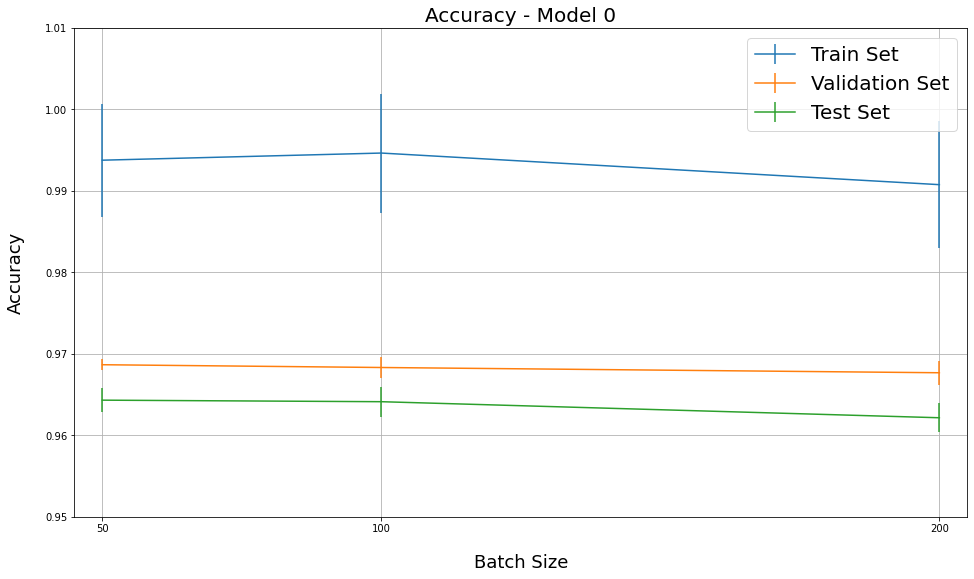

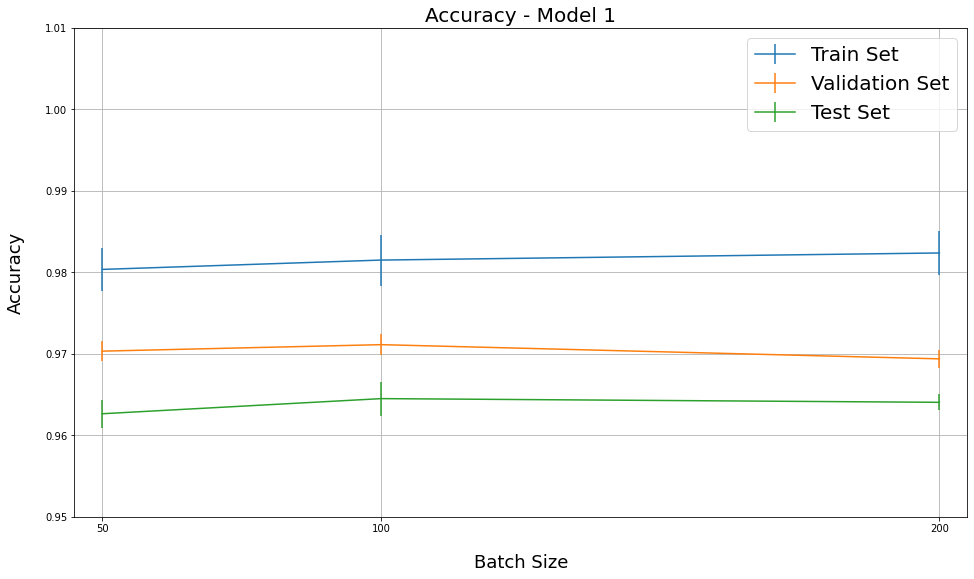

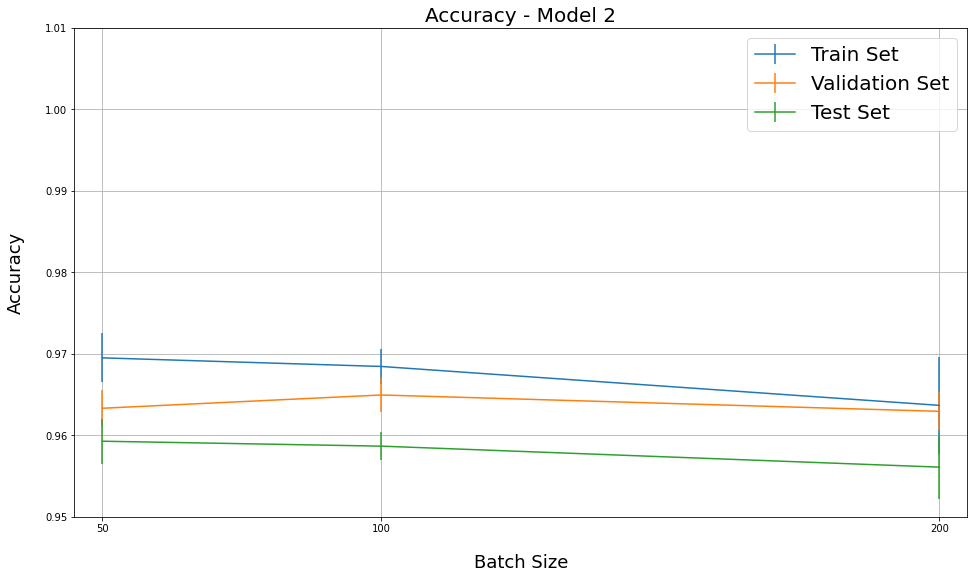

In [ ]:
for model_number in [0, 1, 2]:
    
    model_name = 'model_'+str(model_number)

    batch_list = [50, 100, 200]

    train_acc_mean = []
    val_acc_mean = []
    test_acc_mean = []

    train_acc_std = []
    val_acc_std = []
    test_acc_std = []

    for batch in batch_list:
        train_acc_mean.append(np.mean(np.array(results_dict[model_name][batch]['train_acc'])))
        val_acc_mean.append(np.mean(np.array(results_dict[model_name][batch]['val_acc'])))
        test_acc_mean.append(np.mean(np.array(results_dict[model_name][batch]['test_acc'])))

        train_acc_std.append(np.std(np.array(results_dict[model_name][batch]['train_acc'])))
        val_acc_std.append(np.std(np.array(results_dict[model_name][batch]['val_acc'])))
        test_acc_std.append(np.std(np.array(results_dict[model_name][batch]['test_acc'])))


    plt.figure(figsize= (16,9))

    plt.xticks(batch_list)
    plt.yticks(np.arange(0.9, 1.1, step=0.01))
    plt.xlim((batch_list[0]-5, batch_list[-1]+5))
    plt.ylim((0.95, 1.01))

    plt.xlabel('Batch Size', labelpad=20, fontsize=18)
    plt.ylabel('Accuracy', labelpad=20, fontsize=18)

    plt.title('Accuracy - Model %s' % model_name[-1], fontsize=20)

    plt.errorbar(x=batch_list, y=train_acc_mean, yerr=train_acc_std, label='Train Set')
    plt.errorbar(x=batch_list, y=val_acc_mean, yerr=val_acc_std, label='Validation Set')
    plt.errorbar(x=batch_list, y=test_acc_mean, yerr=test_acc_std, label='Test Set')

    plt.legend(loc=1, prop={'size': 20}, )
    plt.grid()

#     plt.show()
    plt.savefig(results_path+'/plots/acc_model'+model_name[-1]+'.png')

# Dataset Visagio Hackathon

### Classificando Dataset Disponibilizado

In [28]:
for c in range(10):
    column = 'question_' + str(c) + '_answer'
    print(df_Base_Story[column].unique())


['Not Satisfactory' 'Satisfactory' 'Not Applicable']
['Not Satisfactory' 'Satisfactory']
['Not Satisfactory' 'Satisfactory']
['Not Satisfactory' 'Satisfactory' 'Not Applicable']
['Satisfactory' 'Not Satisfactory' 'Not Applicable']
['Not Satisfactory' 'Satisfactory' 'Not Applicable']
['Not Applicable' 'Satisfactory' 'Not Satisfactory']
['Not Applicable' 'Satisfactory' 'Not Satisfactory']
['Not Satisfactory' 'Satisfactory' 'Not Applicable']
['Not Satisfactory' 'Satisfactory' 'Not Applicable']


In [29]:
dictionary = {'Not Satisfactory': -1, 'Satisfactory': 1, 'Not Applicable':0}

for c in range(10):
    column = 'question_' + str(c) + '_answer'
    df_Base_Story[column+'_label'] = [dictionary[row] for row in list(df_Base_Story[column])]

df_Base_Story['quality_score'] = np.sum(np.array(df_Base_Story.iloc[:, -10:]), axis=1)

Tratando o Dataset Base News Releases

In [31]:
for c in range(10):
    column = 'question_' + str(c) + '_answer'
    print(df_Base_News_Releases[column].unique())


['Not Satisfactory' 'Not Applicable' 'Satisfactory']
['Satisfactory' 'Not Satisfactory' 'Not Applicable']
['Satisfactory' 'Not Satisfactory' 'Not Applicable']
['Not Satisfactory' 'Satisfactory' 'Not Applicable']
['Satisfactory' 'Not Satisfactory']
['Not Satisfactory' 'Satisfactory']
['Not Satisfactory' 'Satisfactory' 'Not Applicable']
['Not Satisfactory' 'Satisfactory' 'Not Applicable']
['Satisfactory' 'Not Satisfactory' 'Not Applicable']
['Not Satisfactory' 'Satisfactory' 'Not Applicable']


In [32]:
dictionary = {'Not Satisfactory': -1, 'Satisfactory': 1, 'Not Applicable':0}

for c in range(10):
    column = 'question_' + str(c) + '_answer'
    df_Base_News_Releases[column+'_label'] = [dictionary[row] for row in list(df_Base_News_Releases[column])]

df_Base_News_Releases['quality_score'] = np.sum(np.array(df_Base_News_Releases.iloc[:, -10:]), axis=1)

Label para Fake News: 0 // Label para True: 1

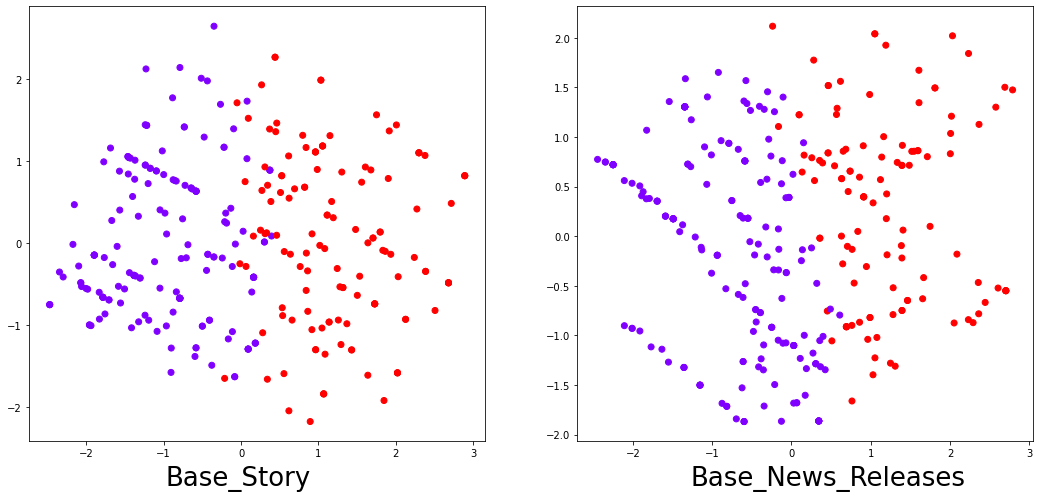

In [34]:
# Classificando cada dataset

columns = ['question_'+str(c)+'_answer_label' for c in range(10)]

arr_stories = np.array(df_Base_Story[columns])
arr_news = np.array(df_Base_News_Releases[columns])

kmeans_stories = KMeans(n_clusters=2, random_state=2)
kmeans_news = KMeans(n_clusters=2, random_state=2)

pca_stories = PCA(n_components=2)
arr_stories_pca = pca_stories.fit_transform(arr_stories)

pca_news = PCA(n_components=2)
arr_news_pca = pca_news.fit_transform(arr_news)


kmeans_news.fit(arr_news)
kmeans_stories.fit(arr_stories)


kmeans_news.labels_ = np.abs(kmeans_news.labels_-1)
df_Base_News_Releases['label'] = np.clip(np.sum(arr_news, axis=1), a_min=0,a_max=1)

df_Base_Story['label'] = np.clip(np.sum(arr_stories, axis=1), a_min=0,a_max=1)

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

ax[0].scatter(arr_stories_pca[:,0], arr_stories_pca[:,1], c=kmeans_stories.labels_, cmap='rainbow')
ax[1].scatter(arr_news_pca[:,0], arr_news_pca[:,1], c=kmeans_news.labels_, cmap='rainbow')

ax[0].text(0.3, -0.1, 'Base_Story', transform=ax[0].transAxes, fontsize=26)
ax[1].text(0.25, -0.1, 'Base_News_Releases', transform=ax[1].transAxes, fontsize=26)

plt.show()

### Limpeza/Tratamento de dados

In [36]:
## Concatenando os DataFrames

df_visagio_complete = pd.concat([df_Base_News_Releases, df_Base_Story], axis=0, ignore_index=True)
df_visagio_complete.title_1 = df_visagio_complete.title_1.astype(str).apply(lambda x: re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", x)).replace('(','').replace(')','').replace('  ',' ').replace('  ',' ').replace('\t','')
list_wrong = ['404 Not Found', 'Are you a robot?']
df_visagio_complete = df_visagio_complete[(~df_visagio_complete.title_1.isin(list_wrong)) & (df_visagio_complete.title_1.notna())]
df_visagio_complete.shape

(591, 60)

### Criando Parâmetros para modelo de AI

In [38]:
Y_visagio = np.array(df_visagio_complete['label']).reshape(-1, 1)

Y_visagio = to_categorical(Y_visagio)

In [39]:
total_upper_rate = []
first_1_upper = []
first_3_upper_count = []

for i in range(df_visagio_complete.shape[0]):
    upper_count = 0
    first_3 = 0
    
    words = df_visagio_complete['title_1'].iloc[i]
    words = words.split(' ')
    
    for w in words:
        if w.isupper(): upper_count += 1
            
    total_upper_rate.append(upper_count/len(words))
            
    
    first_1_upper.append(words[0].isupper())
    
    
    for w in words[:3]:
        if w.isupper(): first_3 += 1
            
    first_3_upper_count.append(first_3)
    

df_visagio_complete['total_upper_rate'] = total_upper_rate
df_visagio_complete['first_1_upper'] = first_1_upper
df_visagio_complete['first_3_upper_count'] = first_3_upper_count
df_visagio_complete['exclamation_count'] = df_visagio_complete['title_1'].str.count('!')
df_visagio_complete['title_len'] = df_visagio_complete['title_1'].str.len()
arr_len = np.array(df_visagio_complete['title_len'])
df_visagio_complete = df_visagio_complete[df_visagio_complete['title_len']<=121]


In [46]:
numerical_parameters_visagio = np.array(df_visagio_complete[['total_upper_rate', 'first_3_upper_count', 'exclamation_count']])

In [47]:
numerical_parameters_visagio

array([[0.        , 0.        , 0.        ],
       [0.11111111, 1.        , 0.        ],
       [0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

In [48]:
X_visagio = normalizer.transform(numerical_parameters_visagio.T)

X_visagio = X_visagio.T 

X_visagio = np.append(X_visagio, (np.array(df_visagio_complete['first_1_upper'])*1.0).reshape(-1, 1), axis=1)

In [50]:
Y_visagio = np.array(df_visagio_complete['label']).reshape(-1, 1)

Y_visagio = to_categorical(Y_visagio)

In [51]:
data_path_visagio = '/content/drive/Shareddrives/Hackathon Visagio/Models/df_visagio_fakehealth/data/'

In [52]:
df_visagio_complete.to_csv(data_path_visagio + 'df.csv')

np.save(data_path_visagio + 'titles.npy', np.array(df_visagio_complete['title_1']))
np.save(data_path_visagio + 'total_upper_rate.npy', np.array(df_visagio_complete['total_upper_rate']))
np.save(data_path_visagio + 'first_1_upper.npy', np.array(df_visagio_complete['first_1_upper']))
np.save(data_path_visagio + 'first_3_upper_count.npy', np.array(df_visagio_complete['first_3_upper_count']))
np.save(data_path_visagio + 'label.npy', np.array(df_visagio_complete['label']))

np.save(data_path_visagio + 'X_visagio.npy', X_visagio)
np.save(data_path_visagio + 'Y_visagio.npy', Y_visagio)

In [53]:
%%time

titles = df_visagio_complete['title_1']

embeddings_titles_visagio_complete = bc.encode(list(titles))

np.save(data_path_visagio+'title_embeddings_visagio.npy', embeddings_titles_visagio_complete)

CPU times: user 3.57 ms, sys: 2.09 ms, total: 5.66 ms
Wall time: 5.54 s


In [54]:
EMB_visagio = embeddings_titles_visagio_complete.copy()

np.save(data_path_visagio + 'EMB_visagio.npy', EMB_visagio)

In [55]:
embeddings_titles_visagio_complete = np.load(data_path_visagio+ 'EMB_visagio.npy')

### Análise de Clusterização (KMeans)

In [56]:
bert_pca_visagio = PCA(n_components=2, random_state=10)
bert_arr_pca_visagio = bert_pca_visagio.fit_transform(embeddings_titles_visagio_complete)

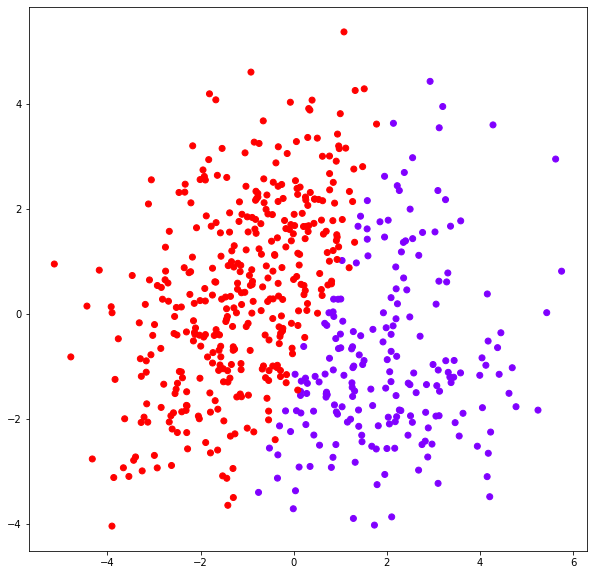

CPU times: user 600 ms, sys: 374 ms, total: 974 ms
Wall time: 547 ms


In [57]:
%%time

bert_kmeans_visagio = KMeans(n_clusters=2, random_state=2)

bert_kmeans_visagio.fit(embeddings_titles_visagio_complete)

plt.figure(figsize=(10,10))
plt.scatter(bert_arr_pca_visagio[:,0], bert_arr_pca_visagio[:,1], c=bert_kmeans_visagio.labels_, cmap='rainbow')
# plt.scatter(bert_kmeans.cluster_centers_[:,0], bert_kmeans.cluster_centers_[:,1], color='black', marker = 'x')
plt.show()

# Evaluation - Modelos de Detecção de Fake News (TensorFlow) no dataset FakeHealth (Disponibilizado)

In [58]:

X_visagio = np.load(data_path_visagio + 'X_visagio.npy')
EMB_visagio = np.load(data_path_visagio + 'EMB_visagio.npy')
Y_visagio = np.load(data_path_visagio + 'Y_visagio.npy')

In [59]:
data_path_visagio

'/content/drive/Shareddrives/Hackathon Visagio/Models/df_visagio_fakehealth/data/'

In [60]:
EMB_visagio

array([[ 0.10336035,  0.17610884,  0.28731495, ..., -0.6893144 ,
        -0.6401597 , -0.1706616 ],
       [-0.152177  ,  0.01275488,  0.27832973, ..., -0.7974511 ,
        -0.4008687 , -0.01736609],
       [-0.06781064, -0.1105954 ,  0.1333343 , ..., -0.53321964,
        -0.7342004 , -0.32439157],
       ...,
       [ 0.02717259, -0.10212723,  0.10397712, ..., -0.24259125,
        -0.17646131, -0.10952365],
       [ 0.10387289, -0.4288159 , -0.1553916 , ..., -0.6653011 ,
        -0.53711396,  0.09294912],
       [-0.21669684, -0.206079  ,  0.13305235, ...,  0.05924072,
        -0.25507262, -0.25143516]], dtype=float32)

In [61]:
data_path

'/content/drive/Shareddrives/Hackathon Visagio/Models/df_kaggle_visagio/data/'

In [62]:
model_number = 1
batch = 100
init = 8

model_filename = '/content/drive/Shareddrives/Hackathon Visagio/Models/df_kaggle_visagio/saved_models/' + 'model__init_{}__model_{}__batch_{}.hdf5'.format(str(init), str(model_number), str(batch))
model = tf.keras.models.load_model(model_filename, compile=False)

visagio_predictions = model.predict([X_visagio, EMB_visagio.reshape(-1, 768, 1)])
visagio_acc = accuracy_score(Y_visagio.argmax(axis=1), visagio_predictions.argmax(axis=1))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [63]:
visagio_acc

0.4421416234887737

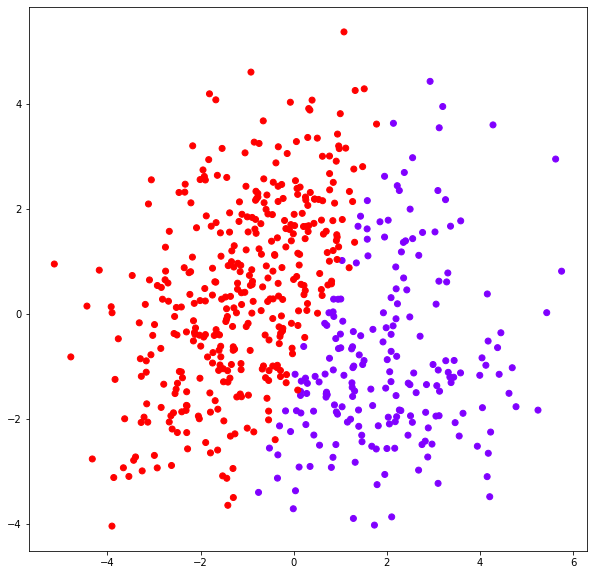

CPU times: user 596 ms, sys: 360 ms, total: 955 ms
Wall time: 535 ms


In [64]:
%%time

bert_kmeans_visagio = KMeans(n_clusters=2, random_state=2)

bert_kmeans_visagio.fit(embeddings_titles_visagio_complete)

plt.figure(figsize=(10,10))
plt.scatter(bert_arr_pca_visagio[:,0], bert_arr_pca_visagio[:,1], c=bert_kmeans_visagio.labels_, cmap='rainbow')
# plt.scatter(bert_kmeans.cluster_centers_[:,0], bert_kmeans.cluster_centers_[:,1], color='black', marker = 'x')
plt.show()

## Análise Sentimental nas Fake News Detectadas

In [79]:
fake_news_boolean = visagio_predictions[:,0] > 0.5
fake_news_tweets = df_tweets[df_tweets.key.isin(df_visagio_complete[fake_news_boolean].id)].dropna()


In [ ]:
# Carregando Modelo de Análise Sentimental
def test_model(input_data: str):
    #  Load saved trained model
    loaded_model = spacy.load(local_folder + "/model_artifacts")
    # Generate prediction
    parsed_text = loaded_model(input_data)
    # Determine prediction to return
    if parsed_text.cats["pos"] > parsed_text.cats["neg"]:
        prediction = "Positive"
        score = parsed_text.cats["pos"]
    else:
        prediction = "Negative"
        score = -parsed_text.cats["neg"]
    return score, prediction
fake_news_tweets['SentimentalAnalysis'] = fake_news_tweets.tweets.apply(lambda x: test_model(x)[0])

In [ ]:
fake_news_tweets.to_csv(data_path + '/SentimentalAnalysis.csv')